# Exploring data notes

Key take-aways from this notebook:
- Churned customers represent 0.27 of the data
- Churned customers seem to pay more per month
- Churned customers seem to have a lower tenure
- The categories with the highest churn are those having to do with payment type/plan, and having to do with a basic service.  In particular Fiber Optic Internet
- Customers who churned sometimes did not have an additional serivce such as online backup, or device protection

In [1]:
import pandas as pd
import itertools
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import acquire
import prepare

rand_seed = prepare.RAND_SEED #to use for the model building

In [2]:
df = prepare.prep_telco(acquire.get_telco_data())

Returning saved csv file.


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [3]:
train, validate, test = prepare.split_telco_data(df)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
5919,8331-ZXFOE,Female,0,No,No,58,Yes,Yes,Yes,Yes,...,Yes,No,No,Yes,71.10,4299.20,No,One year,Credit card (automatic),DSL
1915,2790-XUYMV,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,...,No,No,No,Yes,85.45,6028.95,No,One year,Credit card (automatic),Fiber optic
5054,7107-UBYKY,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,25.75,882.55,No,Month-to-month,Electronic check,None
2355,3373-YZZYM,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.20,19.20,No,Month-to-month,Mailed check,None
6279,8883-GRDWQ,Male,1,No,No,20,Yes,No,Yes,No,...,Yes,No,No,No,54.00,1055.90,No,One year,Mailed check,DSL


In [4]:
train.payment_type.value_counts()

Electronic check             1289
Credit card (automatic)       895
Mailed check                  891
Bank transfer (automatic)     862
Name: payment_type, dtype: int64

In [5]:
train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            3937 non-null   object
 1   gender                 3937 non-null   object
 2   partner                3937 non-null   object
 3   dependents             3937 non-null   object
 4   phone_service          3937 non-null   object
 5   multiple_lines         3937 non-null   object
 6   online_security        3937 non-null   object
 7   online_backup          3937 non-null   object
 8   device_protection      3937 non-null   object
 9   tech_support           3937 non-null   object
 10  streaming_tv           3937 non-null   object
 11  streaming_movies       3937 non-null   object
 12  paperless_billing      3937 non-null   object
 13  churn                  3937 non-null   object
 14  contract_type          3937 non-null   object
 15  payment_type      

## How many customers are churning?

In [6]:
gen_churn = (train.churn == 'Yes').mean()
gen_churn

0.2656845313690627

0.27 of all customers are churning

## What are the general characteristics of the data rows?

### Description of the numeric columns

In [7]:
train.describe().iloc[:,1:]

,tenure,monthly_charges,total_charges
count,3937.000000,3937.000000,3937.000000
mean,32.775210,64.805131,2316.775641
std,24.709604,30.294804,2284.984394
min,1.000000,18.250000,18.850000
25%,9.000000,34.700000,396.100000
50%,30.000000,70.250000,1414.800000
75%,56.000000,90.300000,3893.600000
max,72.000000,118.650000,8594.400000


Compare churned with not churned in the numeric columns

In [8]:
train.groupby('churn').describe().T

churn                           No          Yes
senior_citizen  count  2891.000000  1046.000000
                mean      0.125908     0.259082
                std       0.331803     0.438340
                min       0.000000     0.000000
                25%       0.000000     0.000000
                50%       0.000000     0.000000
                75%       0.000000     1.000000
                max       1.000000     1.000000
tenure          count  2891.000000  1046.000000
                mean     38.003459    18.325048
                std      24.177715    19.960763
                min       1.000000     1.000000
                25%      15.000000     2.000000
                50%      39.000000    10.000000
                75%      61.000000    31.000000
                max      72.000000    72.000000
monthly_charges count  2891.000000  1046.000000
                mean     61.218091    74.719216
                std      31.349533    24.593969
                min      18.250000    18.850000
                25%      25.000000    59.525000
                50%      64.500000    79.850000
                75%      89.025000    94.237500
                max     118.650000   118.350000
total_charges   count  2891.000000  1046.000000
                mean   2583.071792  1580.769742
                std    2343.182641  1934.641968
                min      18.850000    18.850000
                25%     574.425000   116.587500
                50%    1718.200000   699.475000
                75%    4369.550000  2514.025000
                max    8594.400000  8109.800000

Visualize these columns

<AxesSubplot:>

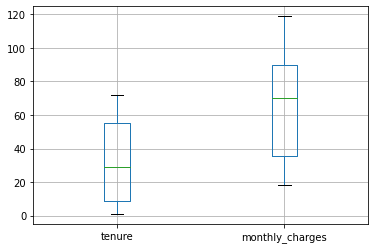

In [9]:
df.boxplot(column = ['tenure', 'monthly_charges'])

<AxesSubplot:>

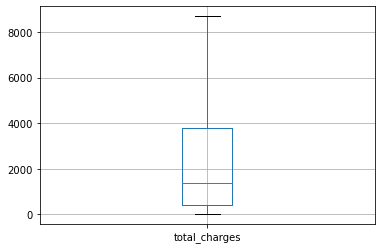

In [10]:
df.boxplot(column = 'total_charges')

Box plots for comparing churn and no churn

array([<AxesSubplot:title={'center':'tenure'}, xlabel='churn'>,
       <AxesSubplot:title={'center':'monthly_charges'}, xlabel='churn'>],
      dtype=object)

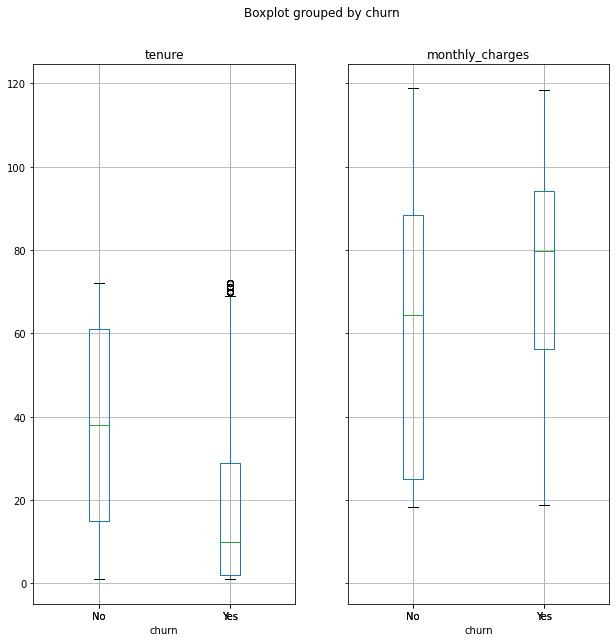

In [11]:
df.boxplot(column = ['tenure', 'monthly_charges'], by= 'churn', figsize=(10,10))

<AxesSubplot:title={'center':'total_charges'}, xlabel='churn'>

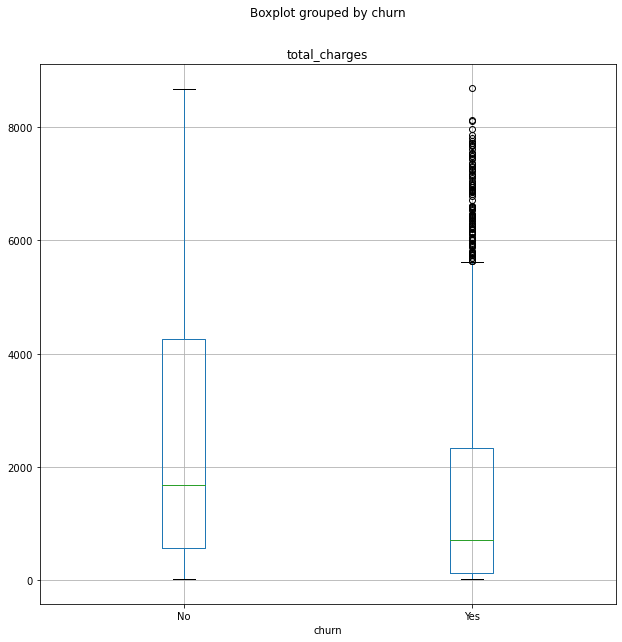

In [12]:
df.boxplot(column = ['total_charges'], by= 'churn', figsize=(10,10))

senior_citizen


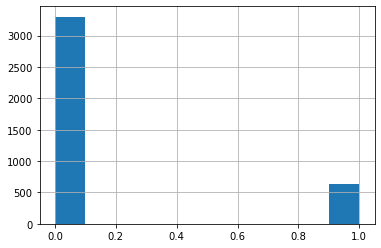

tenure


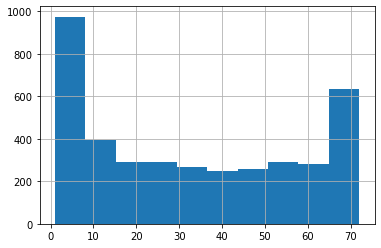

monthly_charges


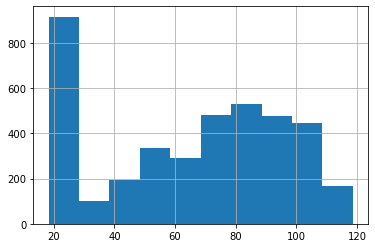

total_charges


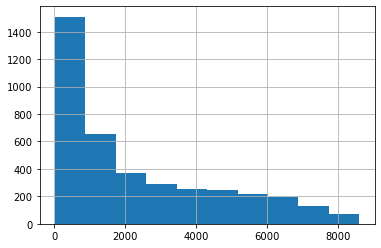

In [13]:
numcols = list(train.select_dtypes(exclude='object').columns)
for col in numcols:
    print(col)
    train[col].hist()
    plt.show()

### Numeric Columns takeaways

- Churning customers have not been with the company for an average of 17 months, compared with 37 for other customers
- Churned customers pay more monthly and in total than non-churning customers

### Catagorical Columns Exploration

##### What is the percent churn in all of the categories? and what proportion of customers do each of these categories represent?

In [14]:
train[train['gender'] == 'Female'].shape[0]/train.shape[0]

0.49809499618999237

In [15]:
#get list of categorical data
cat_var = train.dtypes[train.dtypes == 'object'].index.to_list()
cat_var.remove('customer_id')
cat_var.append('senior_citizen')

#now get the proportion of churn for each one
outputs = []
for cat in cat_var:
    for subcat in list(train[cat].unique()):
        prop = (train[train[cat] == subcat].churn == 'Yes').mean()  
        sample_prop = train[train[cat] == subcat].shape[0]/train.shape[0]
        output = {
            'category':cat,
            'subcategory':subcat,
            'churn_rate':prop,
            'prop_in_sample': sample_prop
        }
        outputs.append(output)

In [16]:
churn_rates = pd.DataFrame(outputs)
churn_rates

,category,subcategory,churn_rate,prop_in_sample
0,gender,Female,0.265681,0.498095
1,gender,Male,0.265688,0.501905
2,partner,No,0.327084,0.514859
3,partner,Yes,0.200524,0.485141
4,dependents,No,0.313297,0.697231
5,dependents,Yes,0.156040,0.302769
6,phone_service,Yes,0.267957,0.905258
7,phone_service,No,0.243968,0.094742
8,multiple_lines,Yes,0.292990,0.423927
9,multiple_lines,No,0.245910,0.481331


Which of these proportions are at least 0.10 above general churn?

In [17]:
high_churn_cats = churn_rates[churn_rates.churn_rate > gen_churn*1.1].sort_values('churn_rate')
high_churn_cats

,category,subcategory,churn_rate,prop_in_sample
8,multiple_lines,Yes,0.292990,0.423927
28,streaming_movies,Yes,0.293965,0.391415
4,dependents,No,0.313297,0.697231
2,partner,No,0.327084,0.514859
29,paperless_billing,Yes,0.335628,0.590297
26,streaming_movies,No,0.345978,0.388367
23,streaming_tv,No,0.351840,0.393447
18,device_protection,No,0.393385,0.430023
16,online_backup,No,0.397171,0.431039
21,tech_support,No,0.416882,0.490475


There seem to be two broad categories here: additional services (streaming movies, online backup, etc), and customer type (contract type, service types, demographic categories).

- Customer type categeories: these are ones that have the highest rates of churn over all the categories.  In particular, fiber optic customers, month-to-month customers, and electronic check customers are significant proportions of the sample and have high churn rates.
    - particular note is senior citizen.  They have a high churn rate, but represent very few of the sample

- Additional services categories : these are generally (1/3) the absence of some service.

### Categorical data takeaways

- The categories with the highest churn are those having to do with payment type/plan, and having to do with a basic service.  In particular Fiber Optic Internet
- Senior citizens had a higher churn rate, but only represented 0.16 of data
- Customers who churned sometimes did not have an additional serivce such as online backup, or device protection
    - These catagories are related to internet service.

# Hypothesis Testing

In [18]:
# do a chi^2 for every combination of categorical variable
outputs = []

alpha = 0.05

for x in itertools.combinations(cat_var, 2):
    obs = pd.crosstab(train[x[0]], train[x[1]])
    chi2, p, degf, expected = stats.chi2_contingency(obs)
    output = {
        'test_categories':f"{x[0]} x {x[1]}",
        'chi2': chi2,
        'p_val': p,
        'reject_null':p < alpha
    }
    outputs.append(output)

In [19]:
chi_tests = pd.DataFrame(outputs)
chi_tests[(chi_tests.reject_null == True) & (chi_tests.test_categories.str.contains('churn'))].sort_values('p_val')

,test_categories,chi2,p_val,reject_null
126,churn x contract_type,664.657249,4.693667e-145,True
76,online_security x churn,510.520615,1.386300e-111,True
103,tech_support x churn,460.871935,8.373959e-101,True
128,churn x internet_service_type,439.766148,3.206227e-96,True
127,churn x payment_type,338.485229,4.643588e-73,True
86,online_backup x churn,326.015433,1.609342e-71,True
95,device_protection x churn,314.354955,5.478843e-69,True
110,streaming_tv x churn,226.175317,7.702893e-50,True
116,streaming_movies x churn,220.438256,1.356566e-48,True
121,paperless_billing x churn,141.364215,1.339372e-32,True


In [20]:
chi_tests[chi_tests.test_categories.str.contains('device')]

,test_categories,chi2,p_val,reject_null
6,gender x device_protection,1.362370,5.060171e-01,False
21,partner x device_protection,112.732504,3.314728e-25,True
35,dependents x device_protection,90.448536,2.287441e-20,True
48,phone_service x device_protection,116.647966,4.679679e-26,True
60,multiple_lines x device_protection,480.828999,9.377191e-103,True
71,online_security x device_protection,4042.971760,0.000000e+00,True
81,online_backup x device_protection,4069.295047,0.000000e+00,True
91,device_protection x tech_support,4141.541613,0.000000e+00,True
92,device_protection x streaming_tv,4239.997040,0.000000e+00,True
93,device_protection x streaming_movies,4228.721871,0.000000e+00,True


In [21]:
train.device_protection

5919                    Yes
1915                     No
5054    No internet service
2355    No internet service
6279                     No
               ...         
394                     Yes
3763                     No
3444    No internet service
1002                     No
4192    No internet service
Name: device_protection, Length: 3937, dtype: object

In [22]:
(chi_tests.reject_null == True).mean()

0.8161764705882353

In [23]:
# now compare churn and non churn for numeric data
# tenure and total_charges are not normal, use a mann whitney
# two sided test to see that they are different

alpha = 0.05
num_col = ['tenure', 'monthly_charges', 'total_charges']

telco_churn = train[train.churn == 'Yes']
telco_nochurn = train[train.churn == 'No']

cols = []
rej = []
p_val = []

for col in num_col:
    cols.append(f"churn x {col}")
    #compare variance
    churn_series = telco_churn[col]
    nochurn_series = telco_nochurn[col]
    #now do the mw test
    t, p = stats.mannwhitneyu(churn_series, nochurn_series, alternative= 'two-sided')
    reject = p/2 < alpha
    rej.append(reject)
    p_val.append(p)

mannw_test = {
    'columns': cols,
    'reject?': rej,
    'p-value':p_val
}
mannw_test = pd.DataFrame(mannw_test)
mannw_test#[mannw_test['reject?']==True].sort_values('p-value')

,columns,reject?,p-value
0,churn x tenure,True,1.746209e-117
1,churn x monthly_charges,True,4.601430e-32
2,churn x total_charges,True,2.346810e-46


In [24]:
#monthly charges might be considered normal.
churn_series = telco_churn['monthly_charges']
nochurn_series = telco_nochurn['monthly_charges']
l_t, l_p = stats.levene(churn_series, nochurn_series)
levene_bool = not l_p < alpha
    #now do the t test
t, p = stats.ttest_ind(churn_series, nochurn_series, equal_var= levene_bool)
p/2 < alpha, p

(True, 2.460130776937842e-43)

#### Hypothesis testing key takeaways

- the $χ^2$ tests confirm what the proportion table shows:
    - contract type (month-to-month) is highly correlated with churn
    - there is a distininction between contract/customer type and additional services
- the numeric columns are all different between churn and non-churn customers

# Building models to predict churn

The positive case is that a customer churns

In [25]:
#encode the data set
train = prepare.telco_make_dummies(train)
validate = prepare.telco_make_dummies(validate)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            3937 non-null   object 
 1   gender                                 3937 non-null   object 
 2   senior_citizen                         3937 non-null   int64  
 3   partner                                3937 non-null   object 
 4   dependents                             3937 non-null   object 
 5   tenure                                 3937 non-null   int64  
 6   phone_service                          3937 non-null   object 
 7   multiple_lines                         3937 non-null   object 
 8   online_security                        3937 non-null   object 
 9   online_backup                          3937 non-null   object 
 10  device_protection                      3937 non-null   object 
 11  t

#### Baseline model

In [27]:
#most of the customers do not churn. baseline model is no one churns
baseline_prediction = train.churn_Yes.value_counts().idxmax()
baseline_model = pd.Series([baseline_prediction for x in range(train.shape[0])])

baseline_accuracy = metrics.classification_report(train.churn_Yes, baseline_model, labels = [0, 1], output_dict=True)['accuracy']
pd.DataFrame(metrics.classification_report(train.churn_Yes, baseline_model, labels = [0, 1], output_dict=True)).T

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/

,precision,recall,f1-score,support
0,0.734315,1.000000,0.846807,2891.000000
1,0.000000,0.000000,0.000000,1046.000000
accuracy,0.734315,0.734315,0.734315,0.734315
macro avg,0.367158,0.500000,0.423404,3937.000000
weighted avg,0.539219,0.734315,0.621824,3937.000000


Take aways from the baseline model.
- assumes that none of the customers churn
- baseline accuracy is 0.73

### Make X and y sets

In [28]:
X_train = train.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = 'churn_Yes')
y_train = train.churn_Yes

X_validate = validate.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = 'churn_Yes')
y_validate = validate.churn_Yes

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   senior_citizen                         3937 non-null   int64  
 1   tenure                                 3937 non-null   int64  
 2   monthly_charges                        3937 non-null   float64
 3   total_charges                          3937 non-null   float64
 4   gender_Male                            3937 non-null   uint8  
 5   partner_Yes                            3937 non-null   uint8  
 6   dependents_Yes                         3937 non-null   uint8  
 7   phone_service_Yes                      3937 non-null   uint8  
 8   multiple_lines_No phone service        3937 non-null   uint8  
 9   multiple_lines_Yes                     3937 non-null   uint8  
 10  online_security_No internet service    3937 non-null   uint8  
 11  o

### Decision tree models
##### For train set

In [30]:
num_tree_depth = 20 #Controls the max depth for the model set. max_depth will range from 2 to this

In [31]:
#positive case is that a customer churns
outputs = []

for i in range(2,num_tree_depth+1):
    clf = DecisionTreeClassifier(max_depth=i, random_state=rand_seed)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    metrics_dict = metrics.classification_report(y_train, y_pred, output_dict=True)
    output = {
        'max_depth': i,
        'accuracy': metrics_dict['accuracy'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [32]:
tree_train_models = pd.DataFrame(outputs)
tree_train_models

,max_depth,accuracy,better_than_baseline
0,2,0.794006,True
1,3,0.794006,True
2,4,0.800610,True
3,5,0.806960,True
4,6,0.817374,True
5,7,0.832106,True
6,8,0.842774,True
7,9,0.859284,True
8,10,0.879858,True
9,11,0.899416,True


All better than baseline! Probably significant overfitting in the ones with more depth.

##### run the models on validate

In [33]:
outputs = []

for i in range(2,num_tree_depth+1):
    clf = DecisionTreeClassifier(max_depth=i, random_state=rand_seed)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict=True)
    output = {
        'max_depth': i,
        'accuracy': metrics_dict['accuracy'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [34]:
tree_validate_models = pd.DataFrame(outputs)
tree_validate_models

,max_depth,accuracy,better_than_baseline
0,2,0.796020,True
1,3,0.796020,True
2,4,0.798863,True
3,5,0.795309,True
4,6,0.790334,True
5,7,0.777541,True
6,8,0.765458,True
7,9,0.769012,True
8,10,0.755508,True
9,11,0.743426,True


As might be expected, the higher depths were overfitting

Compare the train and validate models

In [35]:
tree_compare_models = pd.merge(tree_train_models, tree_validate_models, on='max_depth')
tree_compare_models['difference'] = abs(tree_compare_models['accuracy_x'] - tree_compare_models['accuracy_y'])
#only some of the validate models are not better than baseline
tree_compare_models[(tree_compare_models['better_than_baseline_y'] == True) & (tree_compare_models['difference'] < 0.1)]

,max_depth,accuracy_x,better_than_baseline_x,accuracy_y,better_than_baseline_y,difference
0,2,0.794006,True,0.796020,True,0.002014
1,3,0.794006,True,0.796020,True,0.002014
2,4,0.800610,True,0.798863,True,0.001747
3,5,0.806960,True,0.795309,True,0.011650
4,6,0.817374,True,0.790334,True,0.027040
5,7,0.832106,True,0.777541,True,0.054565
6,8,0.842774,True,0.765458,True,0.077315
7,9,0.859284,True,0.769012,True,0.090272


Candidates for a good model have a depth in the range of $[2,4]$.

Considering the size of the data set and the costs, a depth of 4 is probably ideal.

### Random forest model

In [36]:
model_params = 10

##### Run on the train data

In [37]:
#assume that churn is the positive case
#doesn't like max_depth = 1; need to use zero_division=True for classification_report
depths = list(range(2, model_params+1)) + list(range(2, model_params+1))
leafs = list(range(model_params, 1, -1)) + list(range(2, model_params+1))
values = {'depths':depths, 'leafs':leafs}
outputs = []
for i in range(len(depths)):
    rf = RandomForestClassifier(min_samples_leaf = values['leafs'][i], max_depth=values['depths'][i], random_state=rand_seed)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    metrics_dict = metrics.classification_report(y_train, y_pred, output_dict=True, zero_division=False)
    output = {
        'min_samples_leaf':values['leafs'][i],
        'max_depth':values['depths'][i],
        'accuracy': metrics_dict['accuracy'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [38]:
rand_train_models = pd.DataFrame(outputs)
rand_train_models

,min_samples_leaf,max_depth,accuracy,better_than_baseline
0,10,2,0.766320,True
1,9,3,0.789942,True
2,8,4,0.805690,True
3,7,5,0.806960,True
4,6,6,0.811024,True
5,5,7,0.819660,True
6,4,8,0.825248,True
7,3,9,0.844044,True
8,2,10,0.869952,True
9,2,2,0.766320,True


All are better than baseline!

##### run on the validate set

In [39]:
#assume that churn is the positive case
#doesn't like max_depth = 1; need to use zero_division=True for classification_report
depths = list(range(2, model_params+1)) + list(range(2, model_params+1))
leafs = list(range(model_params, 1, -1)) + list(range(2, model_params+1))
values = {'depths':depths, 'leafs':leafs}
outputs = []
for i in range(len(depths)):
    rf = RandomForestClassifier(min_samples_leaf = values['leafs'][i], max_depth=values['depths'][i], random_state=rand_seed)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict=True, zero_division=False)
    output = {
        'min_samples_leaf':values['leafs'][i],
        'max_depth':values['depths'][i],
        'accuracy': metrics_dict['accuracy'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [40]:
rand_validate_models = pd.DataFrame(outputs)
rand_validate_models

,min_samples_leaf,max_depth,accuracy,better_than_baseline
0,10,2,0.760483,True
1,9,3,0.787491,True
2,8,4,0.800284,True
3,7,5,0.800995,True
4,6,6,0.803838,True
5,5,7,0.804549,True
6,4,8,0.801706,True
7,3,9,0.799574,True
8,2,10,0.803127,True
9,2,2,0.760483,True


Still all better than baseline, and they look a lot closer to the train models

In [41]:
rand_compare_models = rand_train_models.iloc[:, 0:2]
rand_compare_models['train_acc'] = rand_train_models['accuracy']
rand_compare_models['val_acc'] = rand_validate_models['accuracy']
rand_compare_models['difference'] = abs(rand_train_models['accuracy'] - rand_validate_models['accuracy'])

rand_compare_models

,min_samples_leaf,max_depth,train_acc,val_acc,difference
0,10,2,0.766320,0.760483,0.005836
1,9,3,0.789942,0.787491,0.002450
2,8,4,0.805690,0.800284,0.005405
3,7,5,0.806960,0.800995,0.005965
4,6,6,0.811024,0.803838,0.007186
5,5,7,0.819660,0.804549,0.015111
6,4,8,0.825248,0.801706,0.023542
7,3,9,0.844044,0.799574,0.044470
8,2,10,0.869952,0.803127,0.066825
9,2,2,0.766320,0.760483,0.005836


These all seem very comparable and consistent across models. Look at the highest validate accuracy

In [42]:
rand_compare_models.sort_values('val_acc')

,min_samples_leaf,max_depth,train_acc,val_acc,difference
0,10,2,0.766320,0.760483,0.005836
9,2,2,0.766320,0.760483,0.005836
1,9,3,0.789942,0.787491,0.002450
10,3,3,0.789942,0.788913,0.001029
12,5,5,0.807976,0.798863,0.009113
7,3,9,0.844044,0.799574,0.044470
2,8,4,0.805690,0.800284,0.005405
11,4,4,0.805944,0.800284,0.005659
3,7,5,0.806960,0.800995,0.005965
6,4,8,0.825248,0.801706,0.023542


Looks like the best candidate is `min_samples_leaf = 5` and `max_depth = 7`.

### KNN models

In [43]:
k_num = 20

##### Work on train set

In [44]:
#assume the survival is the positive case
outputs = []
for k in range(2, 22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    metrics_dict = metrics.classification_report(y_train, y_pred, output_dict=True)
    output = {
        'k':k,
        'accuracy':metrics_dict['accuracy'],
        'better_than_baseline': metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [45]:
kneigh_train_models = pd.DataFrame(outputs)
kneigh_train_models

,k,accuracy,better_than_baseline
0,2,0.861316,True
1,3,0.858014,True
2,4,0.832868,True
3,5,0.832106,True
4,6,0.819406,True
5,7,0.818644,True
6,8,0.814580,True
7,9,0.814834,True
8,10,0.810262,True
9,11,0.811532,True


All better than baseline! lower seems better

##### Work on validate set

In [46]:
outputs = []
for k in range(2, 22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict=True)
    output = {
        'k':k,
        'accuracy':metrics_dict['accuracy'],
        'better_than_baseline': metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [47]:
kneigh_val_models = pd.DataFrame(outputs)
kneigh_val_models

,k,accuracy,better_than_baseline
0,2,0.764037,True
1,3,0.751244,True
2,4,0.779673,True
3,5,0.769012,True
4,6,0.787491,True
5,7,0.782516,True
6,8,0.784648,True
7,9,0.784648,True
8,10,0.785359,True
9,11,0.788202,True


In [48]:
kneigh_compare_models = pd.merge(kneigh_train_models, kneigh_val_models, on='k')
kneigh_compare_models['difference'] = abs(kneigh_compare_models['accuracy_x'] - kneigh_compare_models['accuracy_y'])
kneigh_compare_models

,k,accuracy_x,better_than_baseline_x,accuracy_y,better_than_baseline_y,difference
0,2,0.861316,True,0.764037,True,0.097279
1,3,0.858014,True,0.751244,True,0.106770
2,4,0.832868,True,0.779673,True,0.053195
3,5,0.832106,True,0.769012,True,0.063094
4,6,0.819406,True,0.787491,True,0.031915
5,7,0.818644,True,0.782516,True,0.036128
6,8,0.814580,True,0.784648,True,0.029931
7,9,0.814834,True,0.784648,True,0.030185
8,10,0.810262,True,0.785359,True,0.024903
9,11,0.811532,True,0.788202,True,0.023330


These are all largely comparable.  There might be a sweet sport at k = 17, 21 in terms of consistency.

### Logistic Regression model

##### Fit to train data

In [49]:
solve_methods = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
outputs = []

for solve_method in solve_methods:
    logit = LogisticRegression(random_state = rand_seed, max_iter=1000,  solver=solve_method)
    logit = logit.fit(X_train, y_train)
    y_pred = logit.predict(X_train)
    metrics_dict = metrics.classification_report(y_train, y_pred, output_dict=True)
    output = {
        'solver':solve_method,
        'accuracy':metrics_dict['accuracy'],
        'better_than_baseline': metrics_dict['accuracy']>baseline_accuracy
    }
    outputs.append(output)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [50]:
log_train = pd.DataFrame(outputs)
log_train

,solver,accuracy,better_than_baseline
0,newton-cg,0.803404,True
1,lbfgs,0.802896,True
2,liblinear,0.802896,True
3,sag,0.781814,True
4,saga,0.779274,True


##### predict on validate

In [51]:
outputs = []
for solve_method in solve_methods:
    logit = LogisticRegression(random_state = rand_seed, max_iter=1000,  solver=solve_method)
    logit = logit.fit(X_train, y_train)
    y_pred = logit.predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict=True)
    output = {
        'solver':solve_method,
        'accuracy':metrics_dict['accuracy'],
        'better_than_baseline': metrics_dict['accuracy']>baseline_accuracy
    }
    outputs.append(output)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [52]:
log_validate = pd.DataFrame(outputs)
log_validate

,solver,accuracy,better_than_baseline
0,newton-cg,0.809524,True
1,lbfgs,0.808102,True
2,liblinear,0.809524,True
3,sag,0.798152,True
4,saga,0.793177,True


In [53]:
log_compare = pd.merge(log_train, log_validate, on='solver')
log_compare['difference'] = abs(log_train['accuracy'] - log_validate['accuracy'])
log_compare.sort_values('accuracy_y')

,solver,accuracy_x,better_than_baseline_x,accuracy_y,better_than_baseline_y,difference
4,saga,0.779274,True,0.793177,True,0.013903
3,sag,0.781814,True,0.798152,True,0.016339
1,lbfgs,0.802896,True,0.808102,True,0.005207
0,newton-cg,0.803404,True,0.809524,True,0.006120
2,liblinear,0.802896,True,0.809524,True,0.006628


The models are more accurate on the validate than the training.  All are pretty good.

libfgs, newton-cg, and liblinear are the best candidates,

# Comparing models

For each model take the three best performing models and comapare them on the test data.  The following are the candidate models:
- Decision Tree with max_depth 2, 3, 4
- Random Forest with (min_sample_leaf, max_depth) of (5, 7), (6, 6), (9, 9)
- KNNeighbor with k 17, 21, 19
- Logistic Regression model

##### Make the test sets

In [54]:
X_train = train.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = ['churn_Yes', 'phone_service_Yes', 'gender_Male'])
y_train = train.churn_Yes

X_validate = validate.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = ['churn_Yes', 'phone_service_Yes', 'gender_Male'])
y_validate = validate.churn_Yes

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   senior_citizen                         3937 non-null   int64  
 1   tenure                                 3937 non-null   int64  
 2   monthly_charges                        3937 non-null   float64
 3   total_charges                          3937 non-null   float64
 4   partner_Yes                            3937 non-null   uint8  
 5   dependents_Yes                         3937 non-null   uint8  
 6   multiple_lines_No phone service        3937 non-null   uint8  
 7   multiple_lines_Yes                     3937 non-null   uint8  
 8   online_security_No internet service    3937 non-null   uint8  
 9   online_security_Yes                    3937 non-null   uint8  
 10  online_backup_No internet service      3937 non-null   uint8  
 11  o

##### make the models and train and predict them

In [56]:
# make the models
DT_2 = DecisionTreeClassifier(max_depth = 2, random_state = rand_seed)
DT_3 = DecisionTreeClassifier(max_depth = 3, random_state = rand_seed)
DT_4 = DecisionTreeClassifier(max_depth = 4, random_state = rand_seed)
RF_5_7 = RandomForestClassifier(min_samples_leaf = 5, max_depth = 7, random_state = rand_seed)
RF_6_6 = RandomForestClassifier(min_samples_leaf = 6, max_depth = 6, random_state = rand_seed)
RF_9_9 = RandomForestClassifier(min_samples_leaf = 9, max_depth = 9, random_state = rand_seed)
KNN_17 = KNeighborsClassifier(n_neighbors=17)
KNN_19 = KNeighborsClassifier(n_neighbors=19)
KNN_21 = KNeighborsClassifier(n_neighbors=21)
logit_lbfgs = LogisticRegression(random_state = rand_seed, max_iter = 200, solver='lbfgs')
logit_newton_cg = LogisticRegression(random_state = rand_seed, max_iter = 200, solver='newton-cg')
logit_liblinear = LogisticRegression(random_state = rand_seed, max_iter = 200, solver = 'liblinear')

models = [
    {
        'name':'Decision Tree 2',
        'model':DT_2
    },
    {
        'name': 'Decision Tree 3',
        'model':DT_3
    },
    {
        'name': 'Decision Tree 4',
        'model':DT_4
    },
    {
        'name': 'Random Forest 5 7',
        'model':RF_5_7
    },
    {
        'name':'Random Forest 6 6',
        'model':RF_6_6
    },
    {
        'name':'Random Forest 9 9',
        'model':RF_9_9
    },
    {
        'name':'KN Neighbors 17',
        'model':KNN_17
    },
    {
        'name':'KN Neighbors 19',
        'model':KNN_19
    },
    {
        'name':'KN Neighbors 21',
        'model':KNN_21
    },
    {
        'name':'Logistic Regression lbfgs',
        'model':logit_lbfgs
    },
    {
        'name':'Logistic Regression newton-cg',
        'model':logit_newton_cg
    },
    {
        'name':'Logistic Regression liblinear',
        'model':logit_liblinear
    }
]

In [57]:
#train the models and make predictions on validate
outputs = []
for model in models:
    model['model'] = model['model'].fit(X_train, y_train)
    y_pred_train = model['model'].predict(X_train)
    metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict = True)
    y_pred = model['model'].predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict = True)
    output = {
        'model': model['name'],
        'train accuracy': metrics_dict_train['accuracy'],
        'train recall':metrics_dict['1']['recall'],
        'validate accuracy': metrics_dict['accuracy'],
        'validate recall':metrics_dict['1']['recall'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [58]:
pd.DataFrame(outputs).sort_values('train accuracy')

,model,train accuracy,train recall,validate accuracy,validate recall,better_than_baseline
0,Decision Tree 2,0.794006,0.403743,0.796020,0.403743,True
1,Decision Tree 3,0.794006,0.403743,0.796020,0.403743,True
8,KN Neighbors 21,0.794514,0.414439,0.789623,0.414439,True
7,KN Neighbors 19,0.796546,0.411765,0.787491,0.411765,True
6,KN Neighbors 17,0.799340,0.422460,0.793177,0.422460,True
2,Decision Tree 4,0.800610,0.486631,0.798863,0.486631,True
10,Logistic Regression newton-cg,0.802388,0.585561,0.809524,0.585561,True
9,Logistic Regression lbfgs,0.802642,0.580214,0.810235,0.580214,True
11,Logistic Regression liblinear,0.802896,0.582888,0.810235,0.582888,True
4,Random Forest 6 6,0.809246,0.486631,0.798152,0.486631,True


Differences between models are marginal.  But will consider the best from each model type.